Dataset shape: (7214, 53)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_variance_threshold.py:122: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


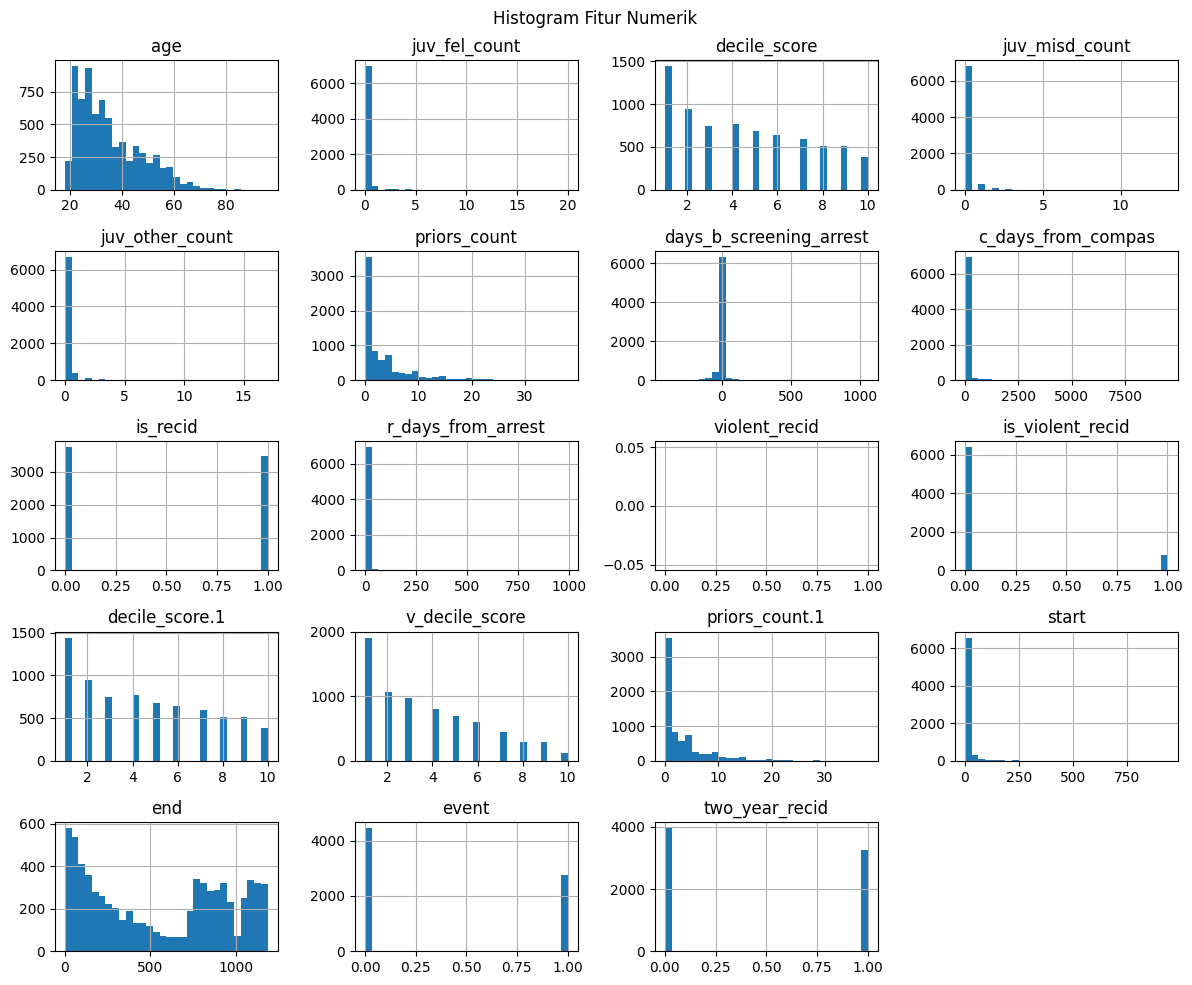

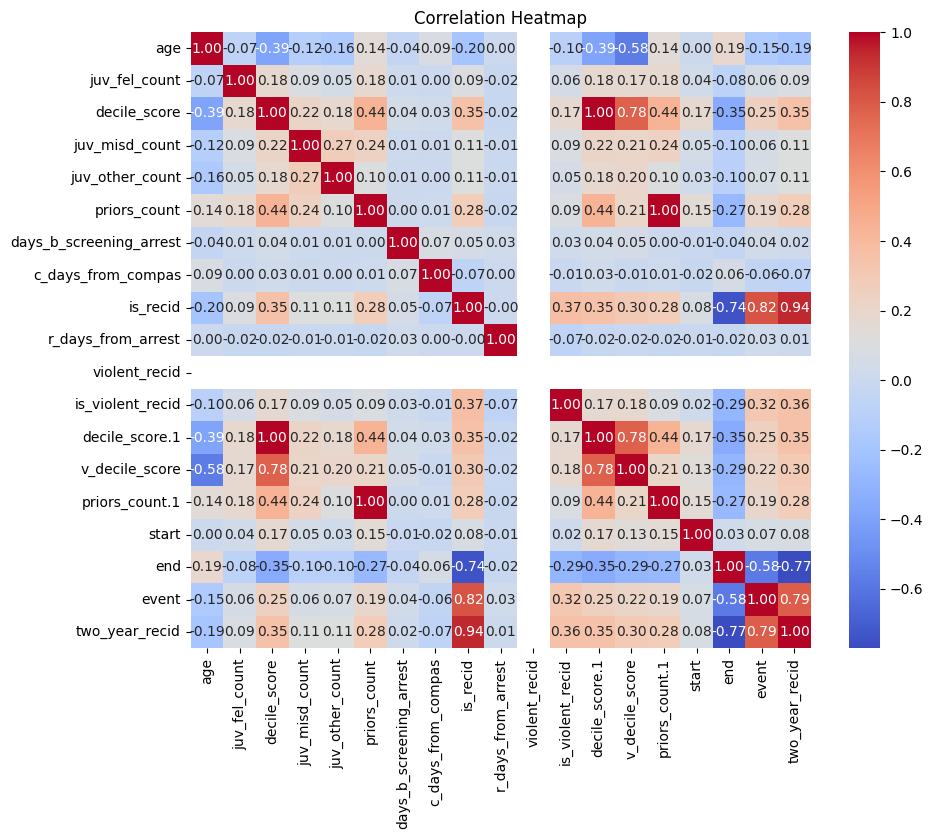

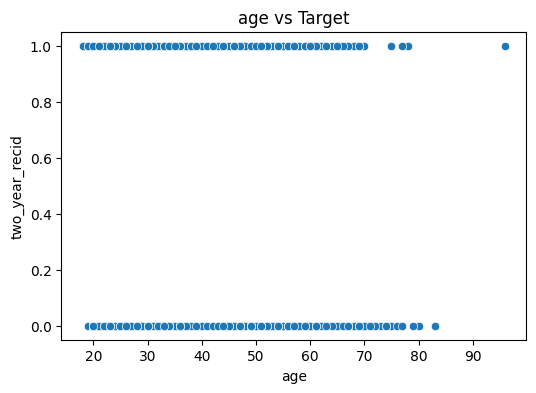

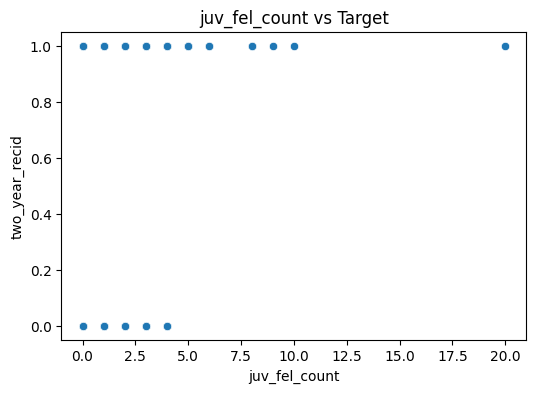

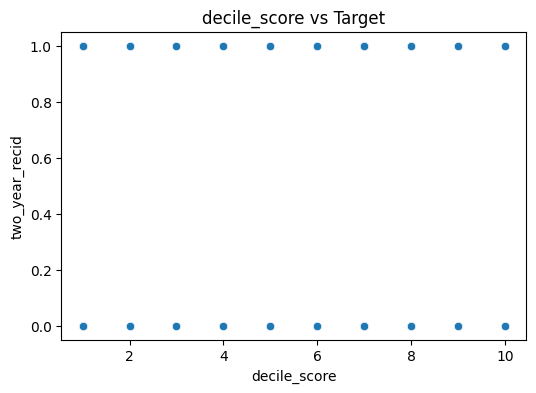

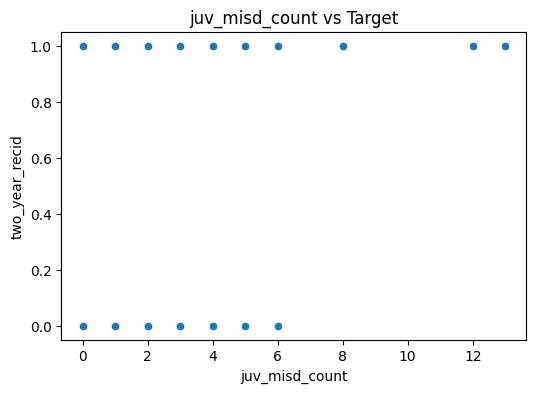

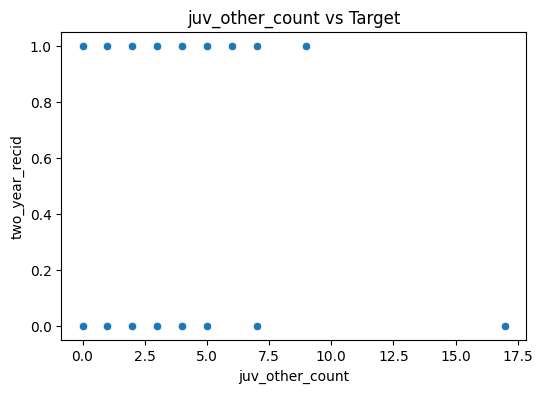

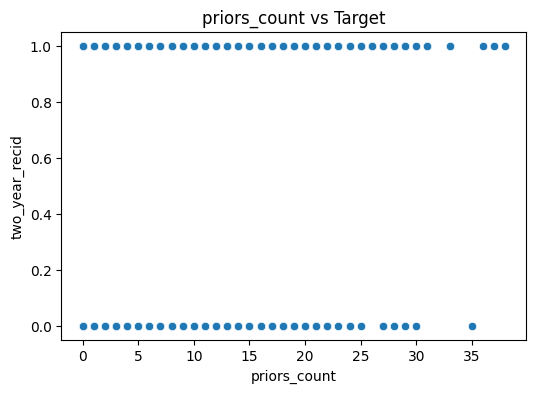

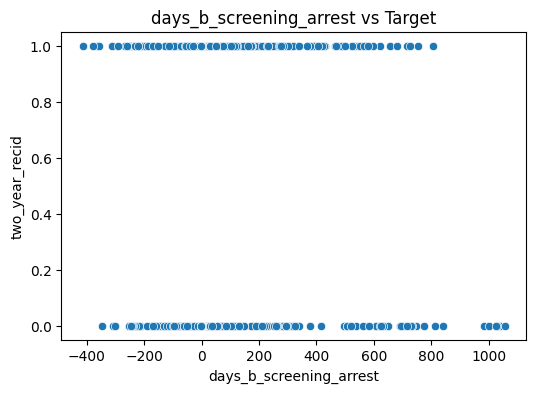

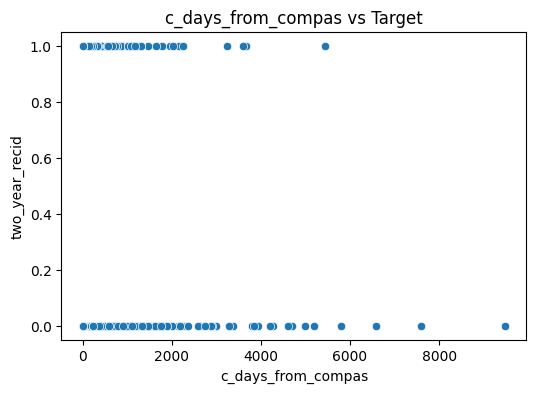

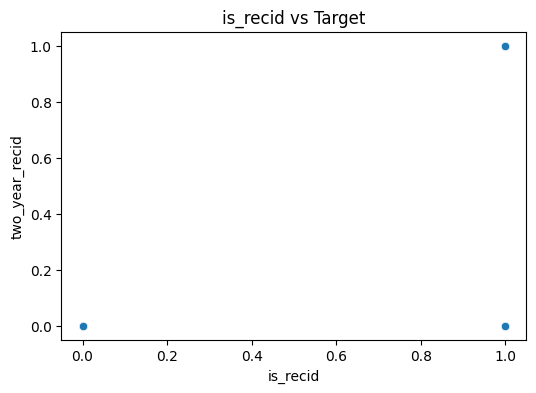

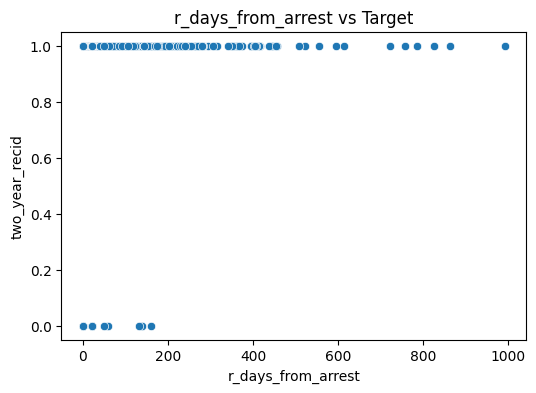

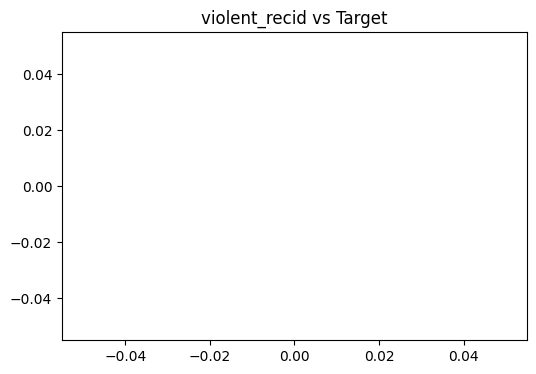

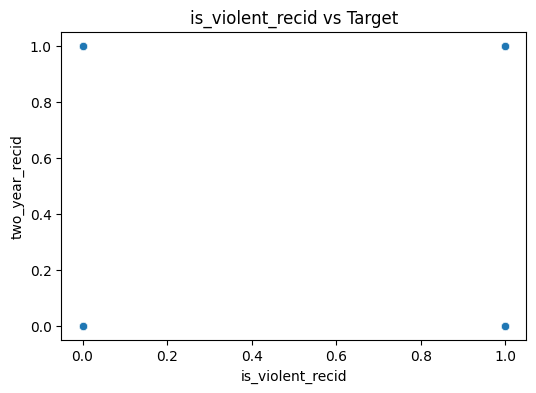

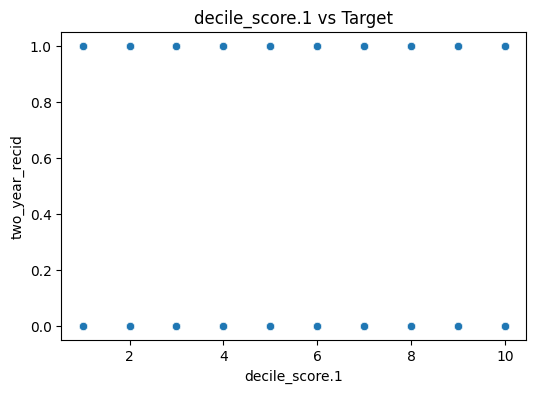

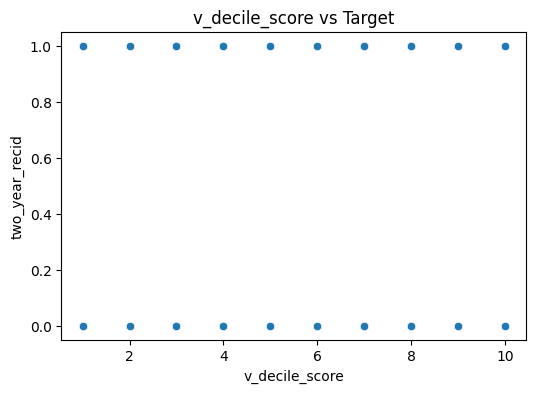

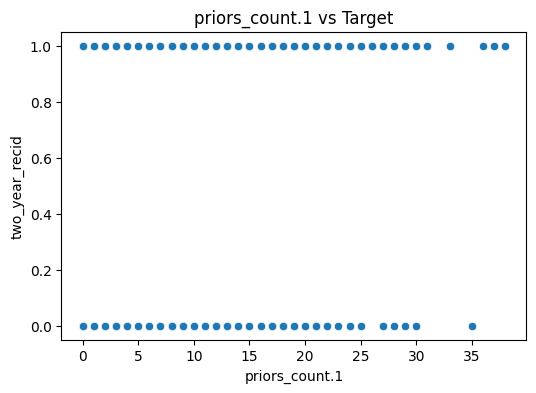

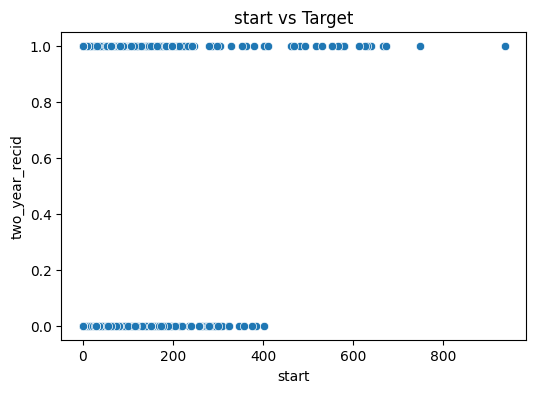

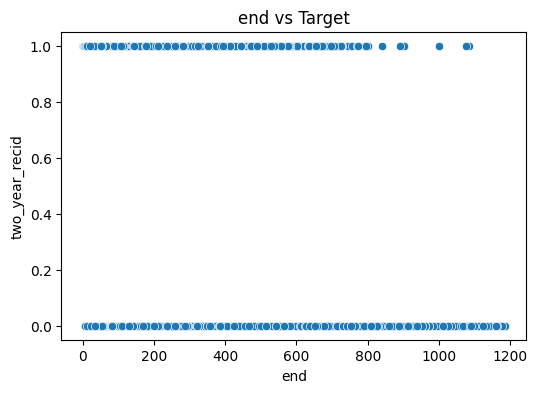

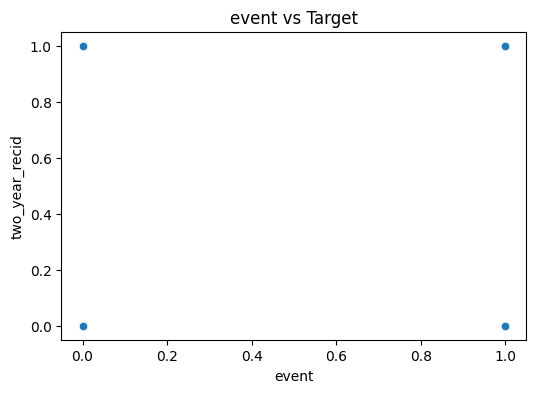

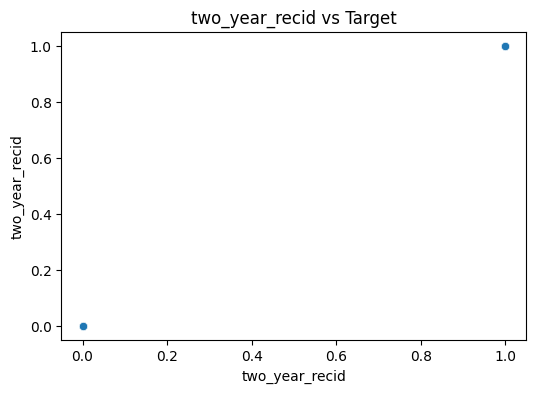

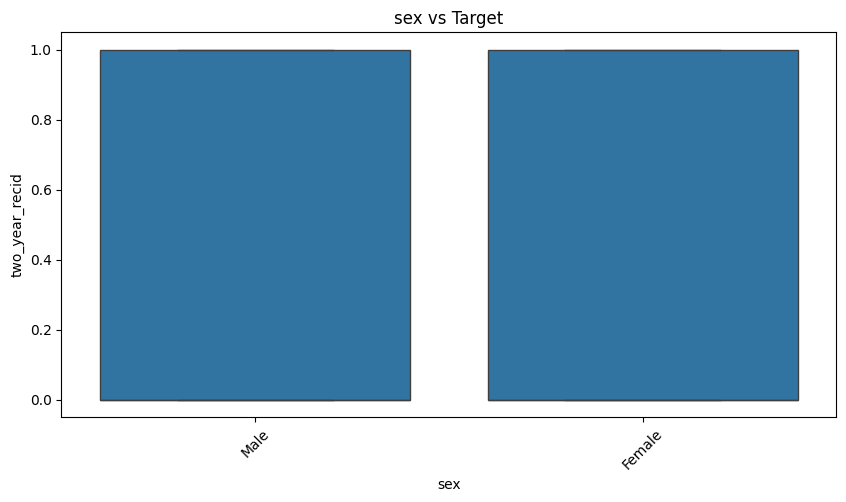

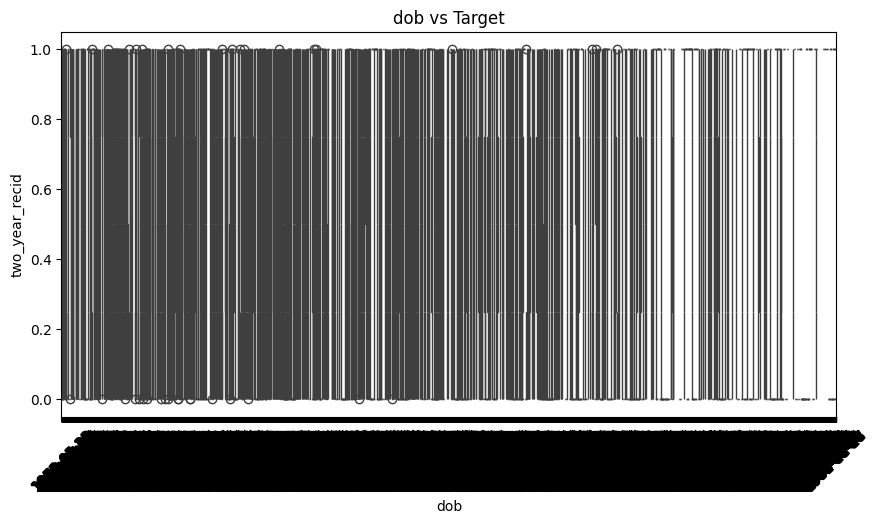

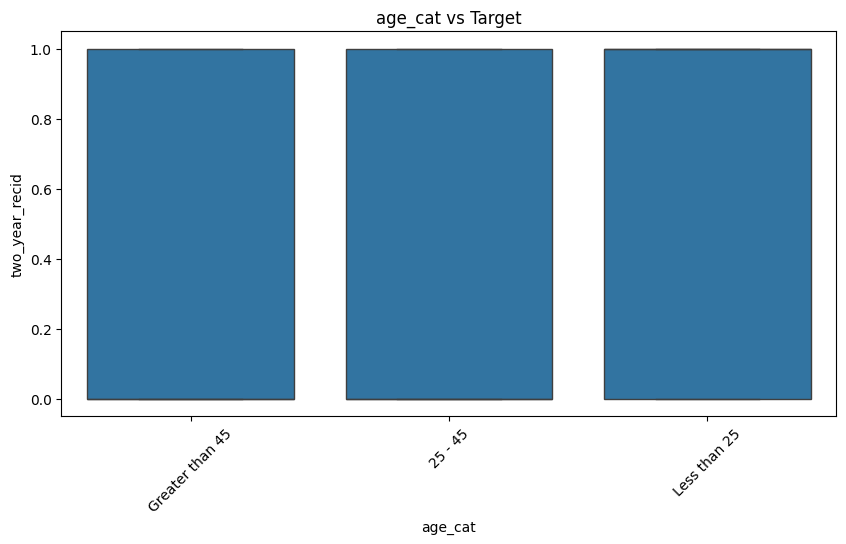

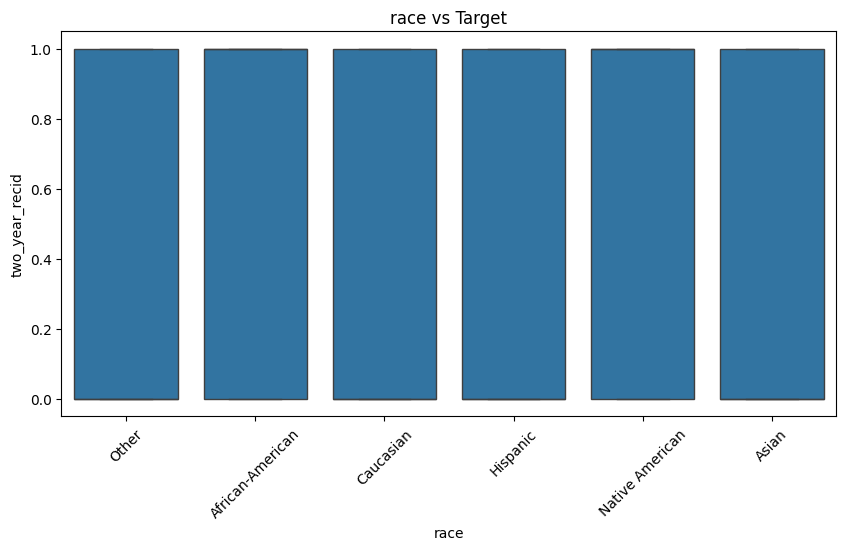

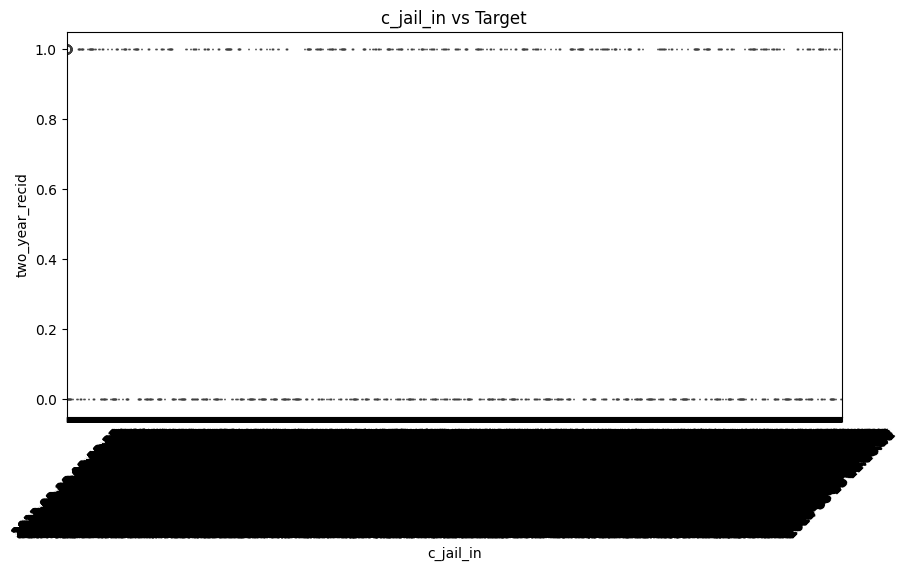

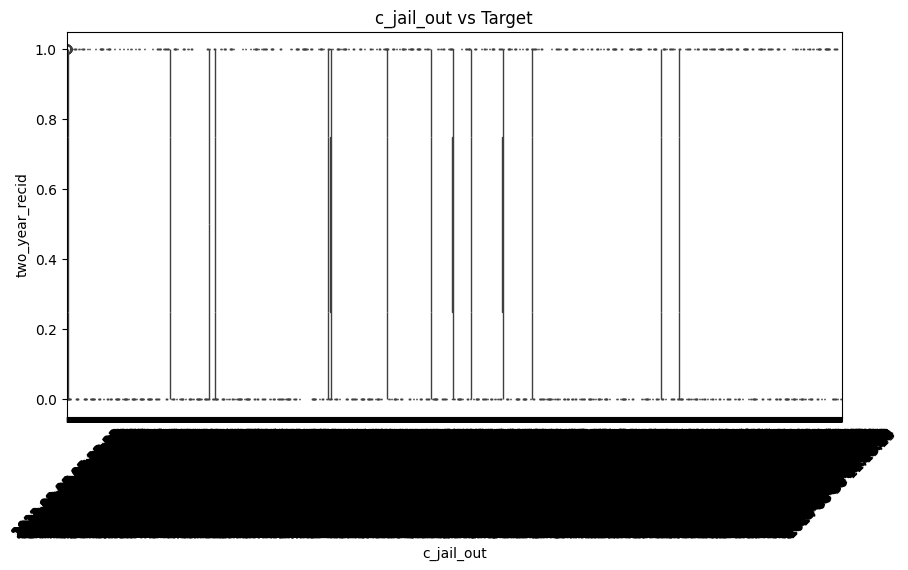

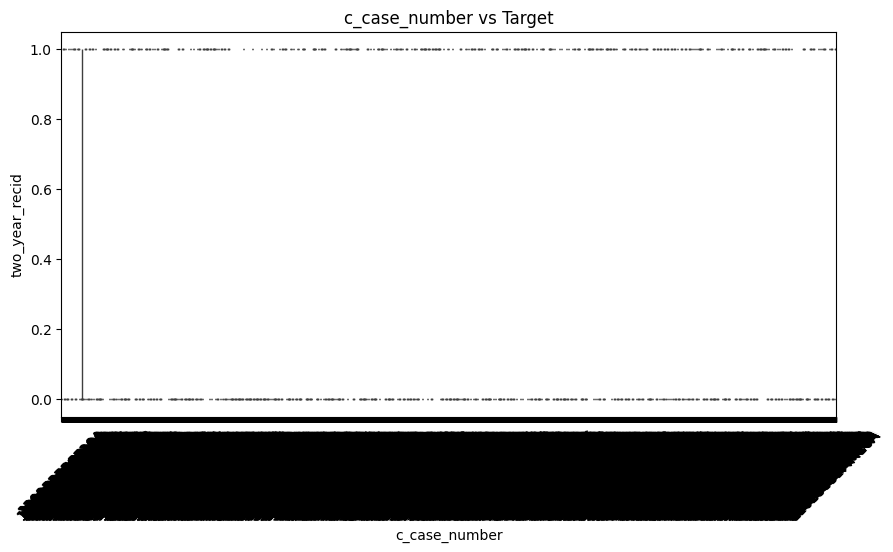

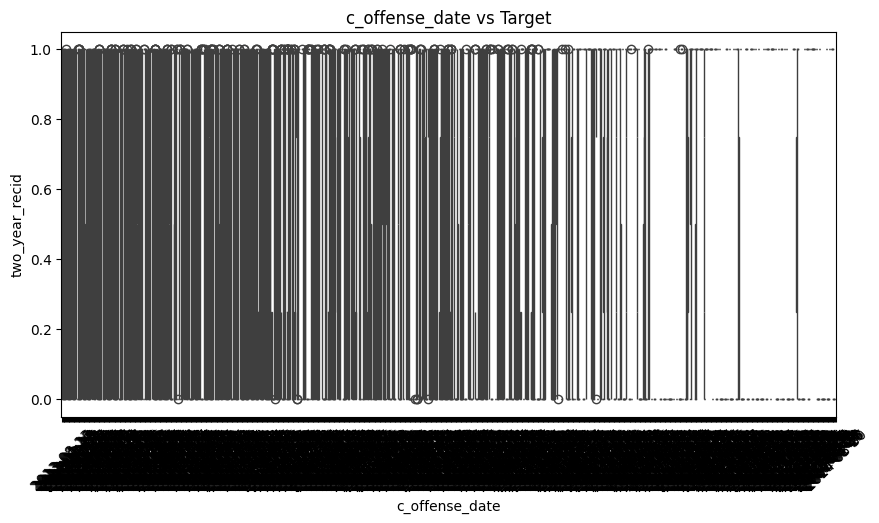

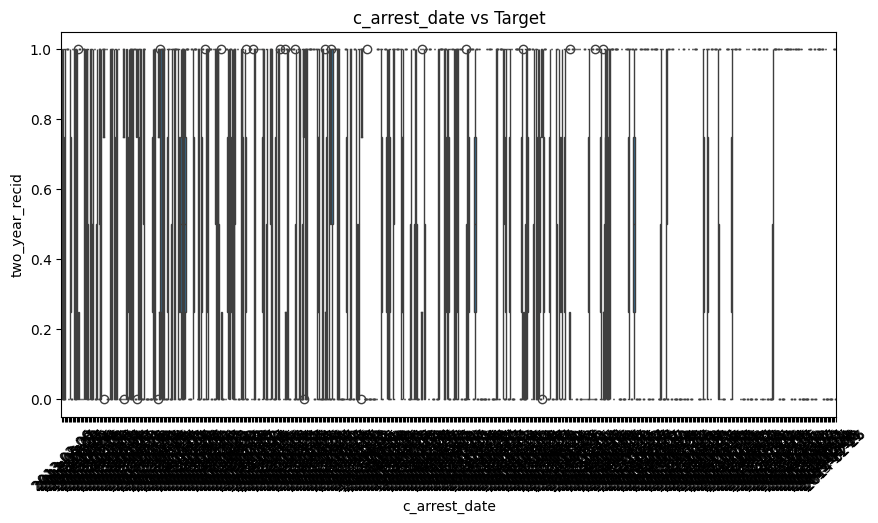

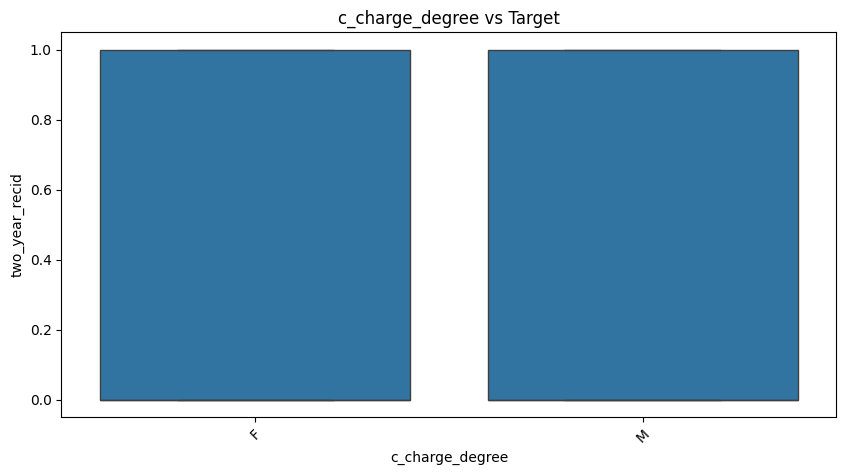

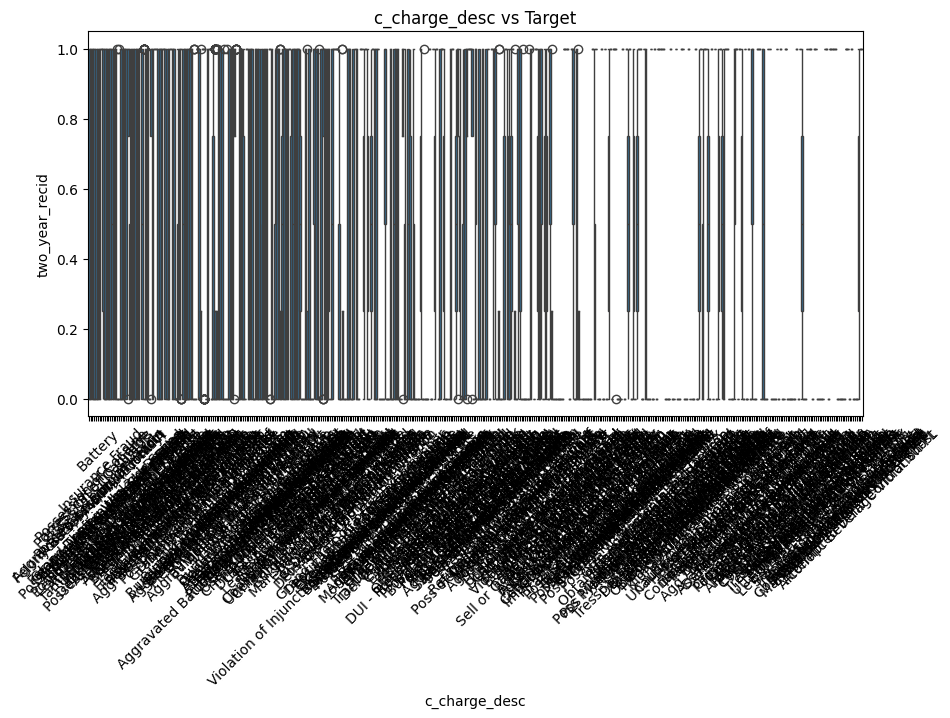

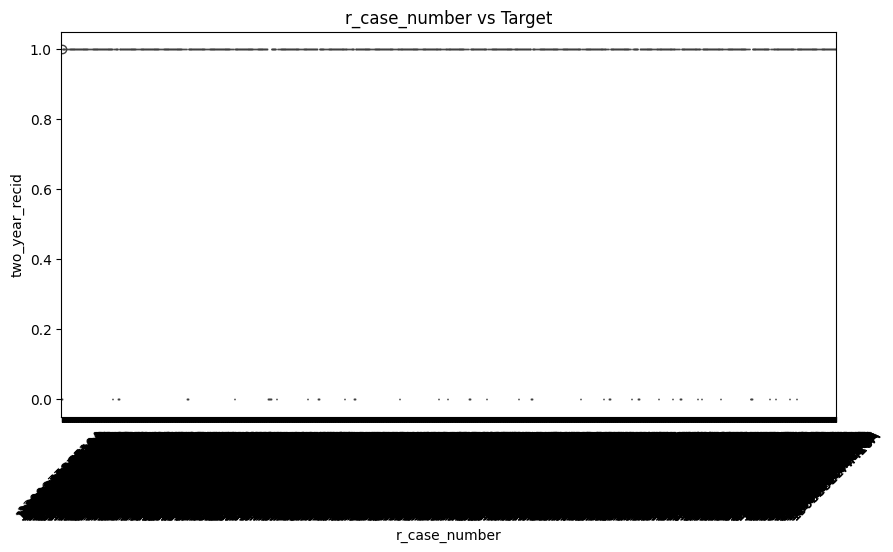

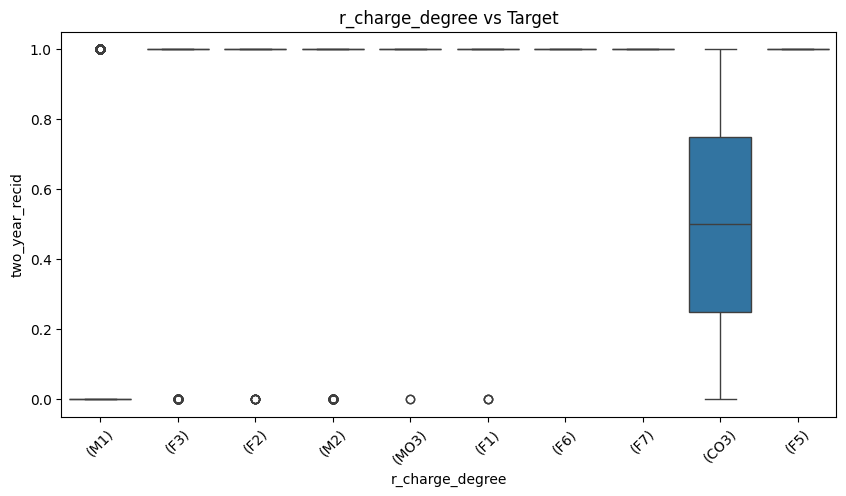

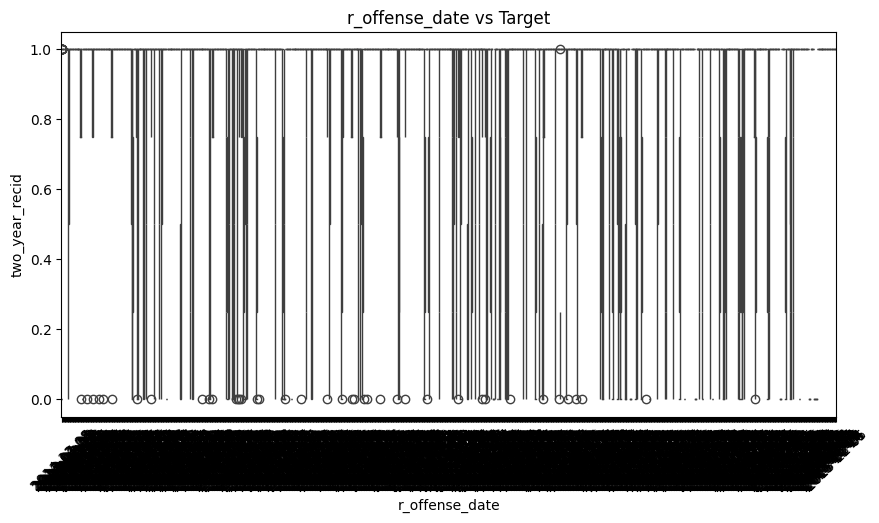

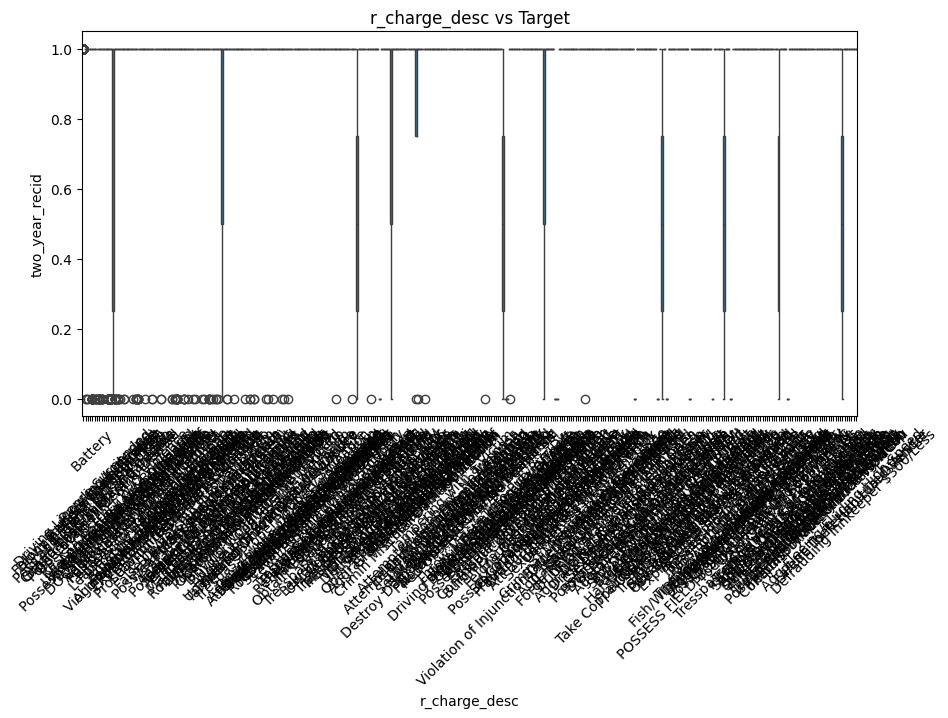

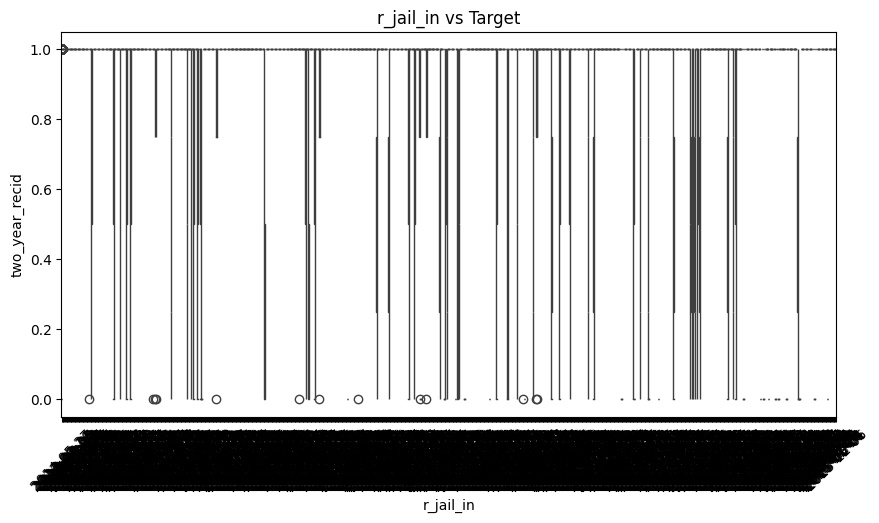

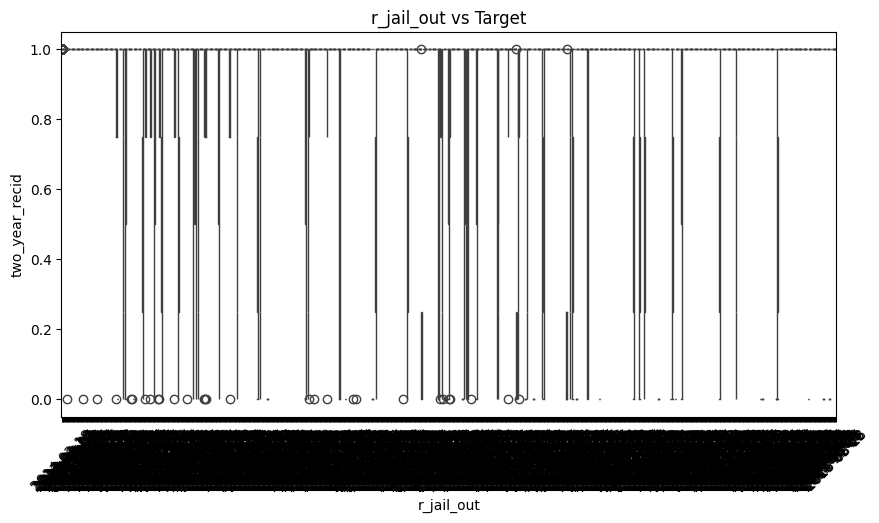

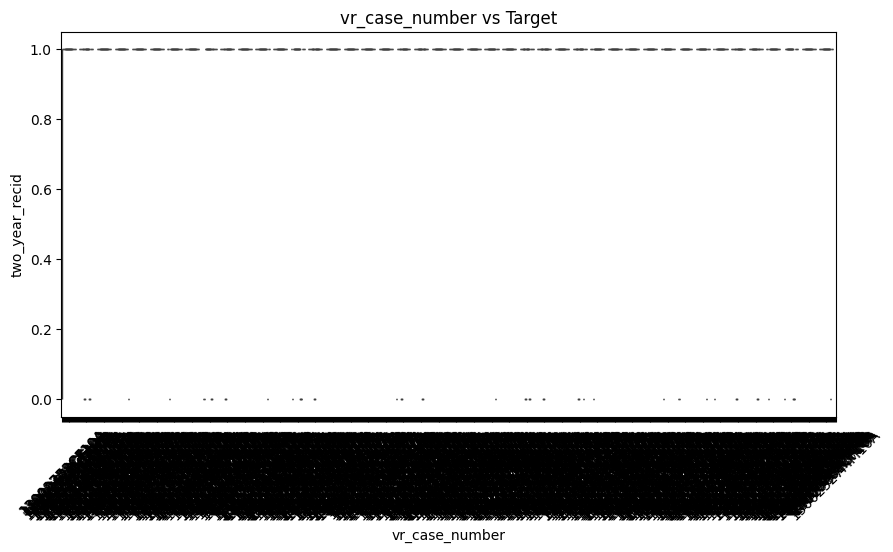

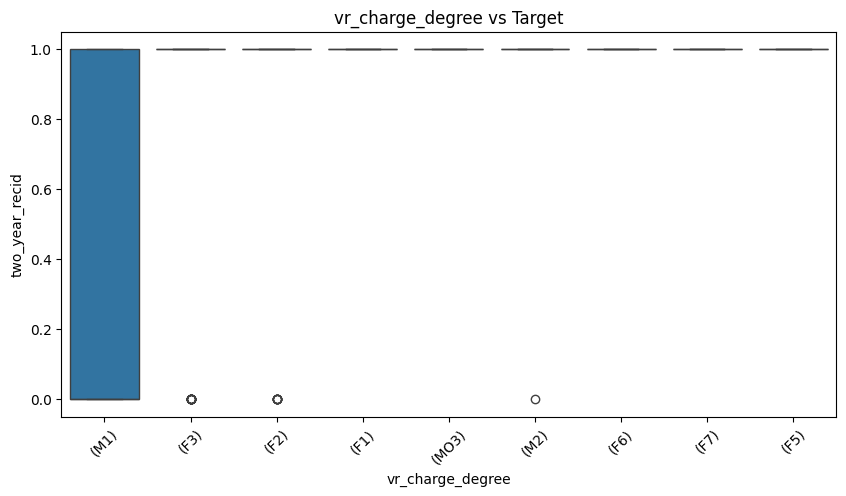

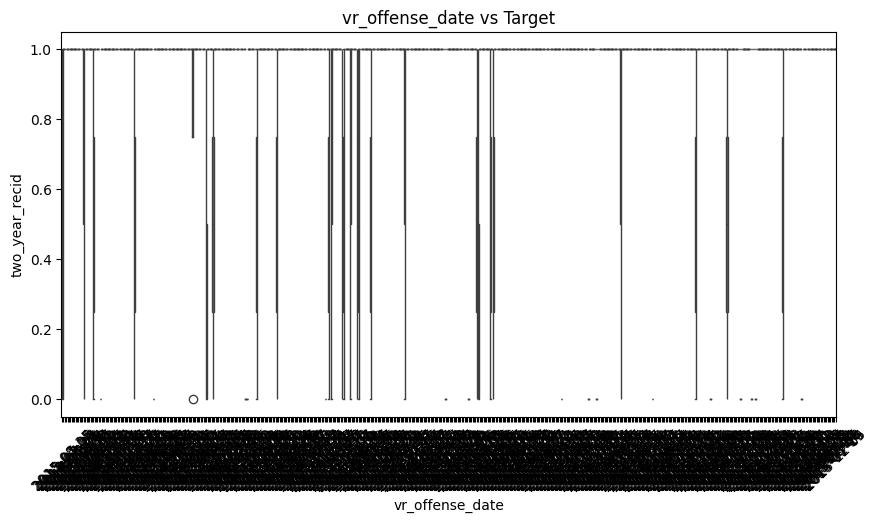

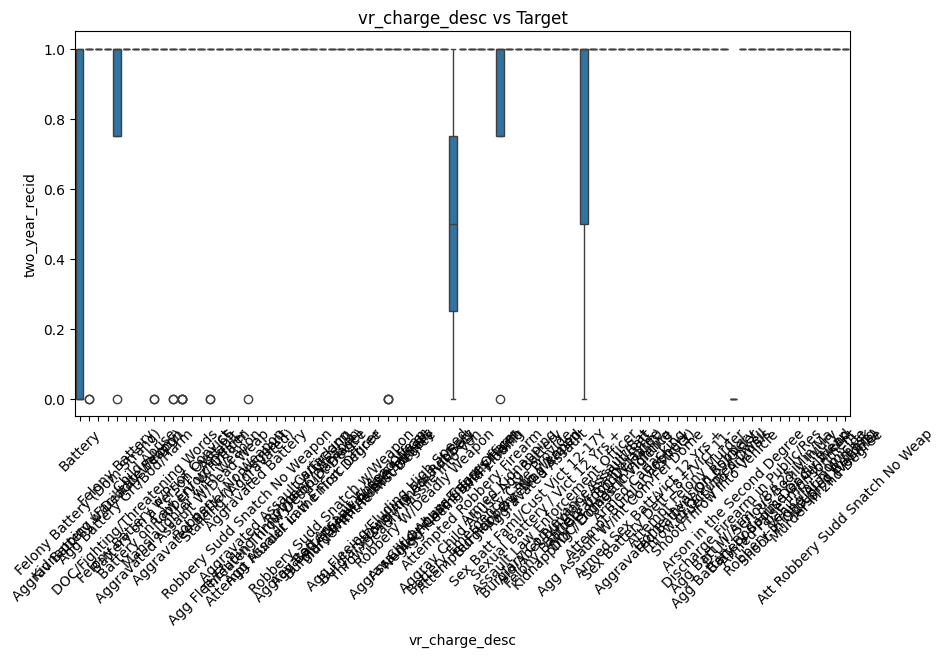

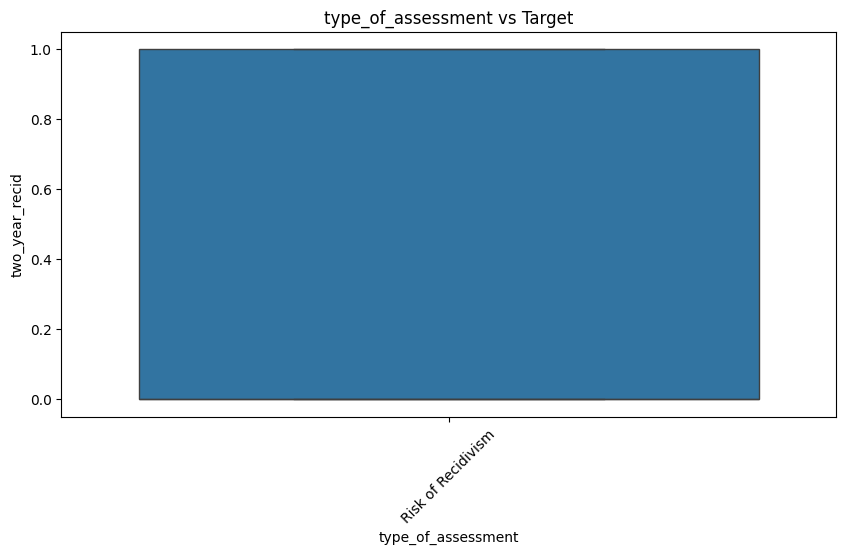

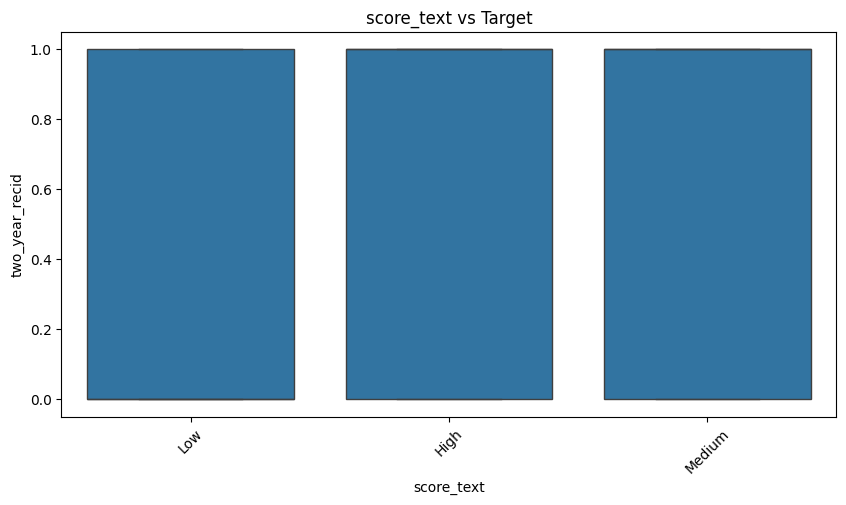

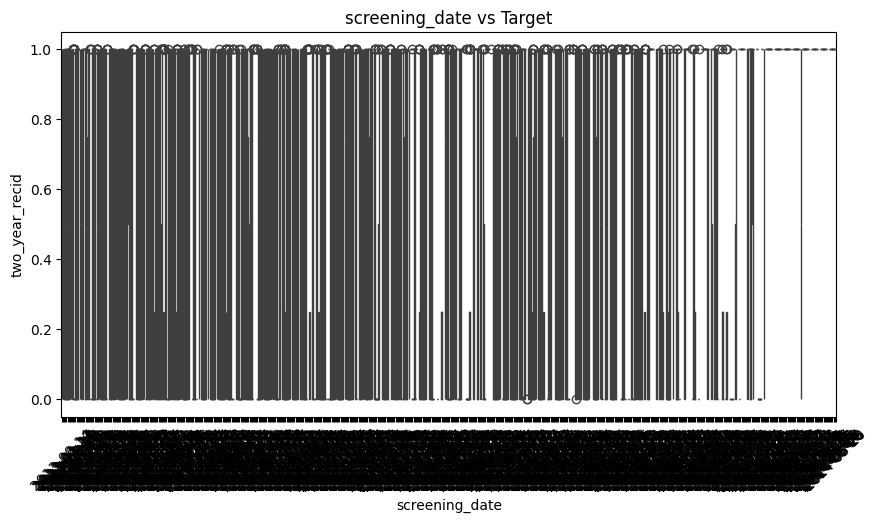

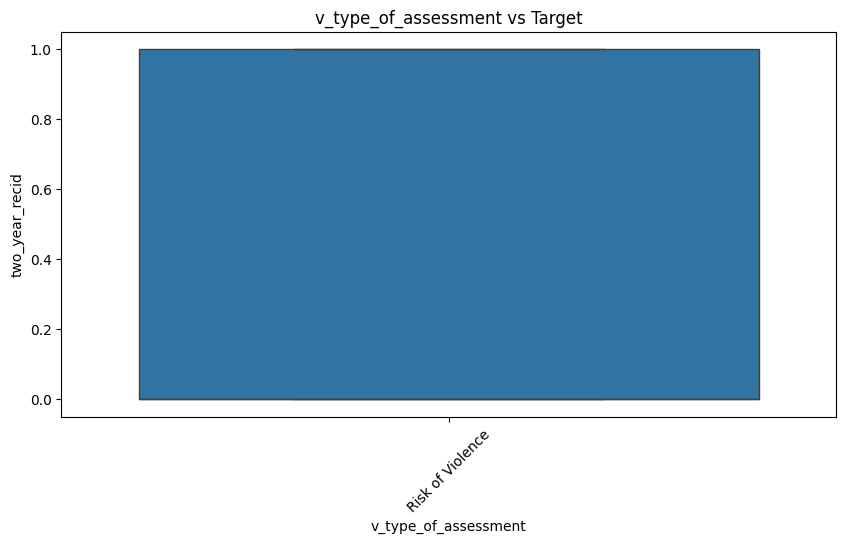

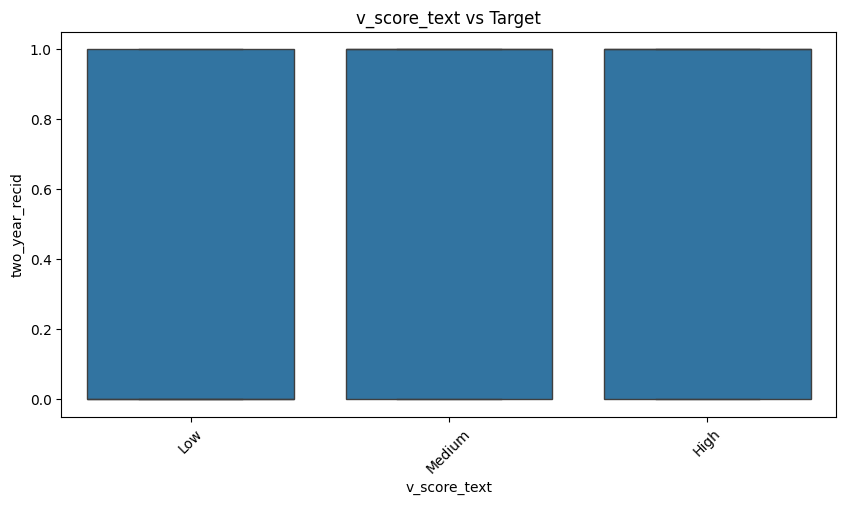

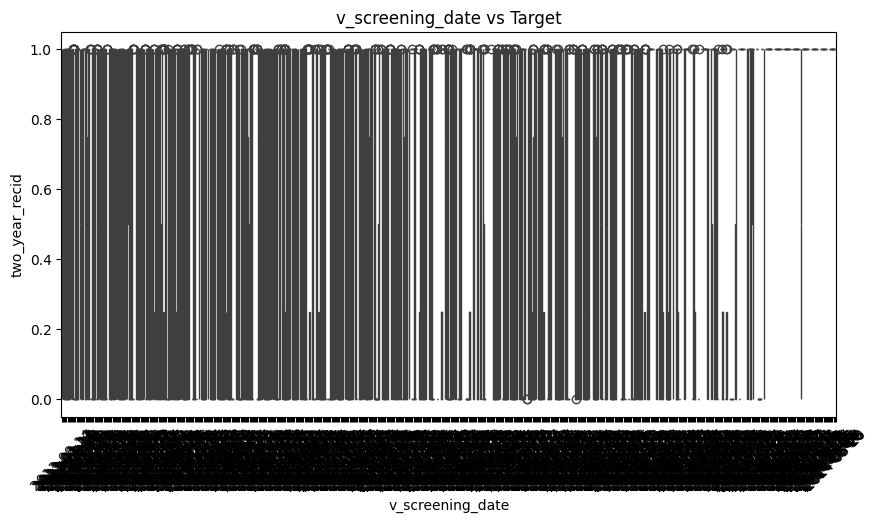

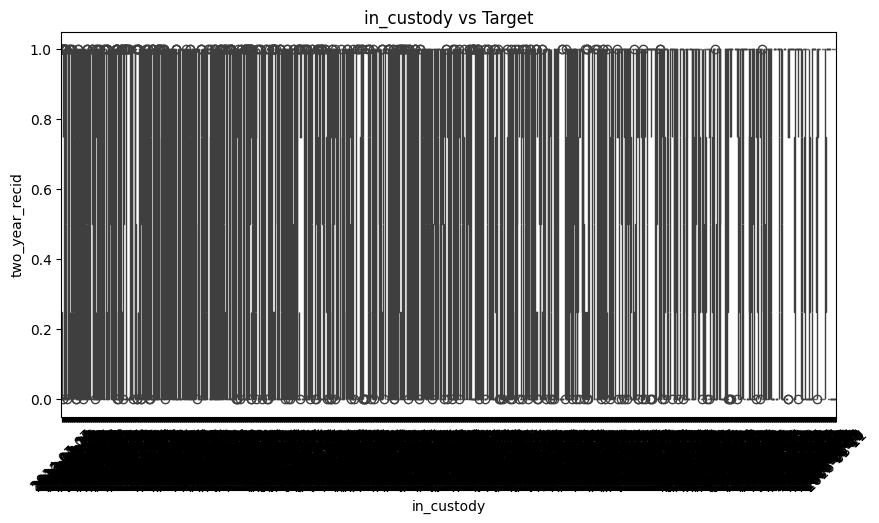

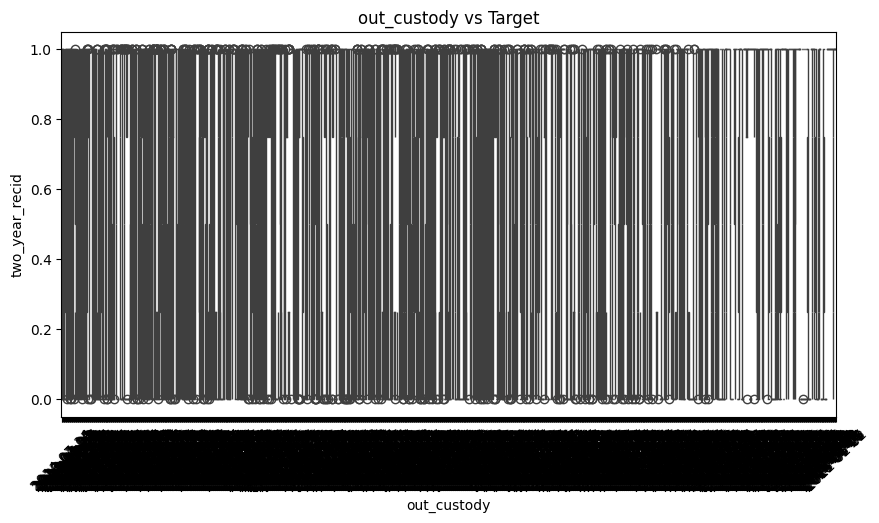

In [ ]:
# ======================
# 📌 LIBRARY IMPORT
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)

# ======================
# 📌 DOWNLOAD & LOAD
# ======================
url_compas = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/04.%20Week%204/Datasets/compas-scores-two-years.csv'
urllib.request.urlretrieve(url_compas, '/content/compas.csv')

df = pd.read_csv('/content/compas.csv')
print(f"Dataset shape: {df.shape}")

# ======================
# 📌 FEATURE ENGINEERING
# ======================
df = df.drop(columns=['id', 'name', 'first', 'last', 'compas_screening_date'], errors='ignore')

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df_encoded = pd.get_dummies(df, drop_first=True)

y = df_encoded['two_year_recid']
X = df_encoded.drop(columns=['two_year_recid'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

selector = VarianceThreshold()
X_train_sel = selector.fit_transform(X_train)
X_val_sel = selector.transform(X_val)
cols = X.columns[selector.get_support()]
X_train = pd.DataFrame(X_train_sel, columns=cols)
X_val = pd.DataFrame(X_val_sel, columns=cols)

X_train.columns = [str(col).replace('[','').replace(']','').replace('<','').replace('>','') for col in X_train.columns]
X_val.columns = X_train.columns

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ======================
# 📌 EDA & VISUALISASI
# ======================

# Hist numerik
df[num_cols].hist(figsize=(12,10), bins=30)
plt.suptitle("Histogram Fitur Numerik")
plt.tight_layout()
plt.show()

# Heatmap korelasi
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter plot
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df['two_year_recid'])
    plt.title(f"{col} vs Target")
    plt.show()

# Boxplot kategorikal
for col in cat_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=df[col], y=df['two_year_recid'])
    plt.title(f"{col} vs Target")
    plt.xticks(rotation=45)
    plt.show()

# ======================
# 📌 MODEL + CROSS-VAL + ROC
# ======================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

def cross_val_and_roc(model, X_data, X_valdata, y_data, y_valdata, model_name):
    acc = cross_val_score(model, X_data, y_data, cv=cv, scoring='accuracy').mean()
    prec = cross_val_score(model, X_data, y_data, cv=cv, scoring='precision').mean()
    rec = cross_val_score(model, X_data, y_data, cv=cv, scoring='recall').mean()
    f1 = cross_val_score(model, X_data, y_data, cv=cv, scoring='f1').mean()
    auc = cross_val_score(model, X_data, y_data, cv=cv, scoring='roc_auc').mean()

    model.fit(X_data, y_data)
    y_prob = model.predict_proba(X_valdata)[:,1]
    fpr, tpr, _ = roc_curve(y_valdata, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_valdata, y_prob):.4f})")

    results[model_name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc
    }

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
cross_val_and_roc(log_model, X_train_scaled, X_val_scaled, y_train, y_val, "Logistic Regression")

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
cross_val_and_roc(tree_model, X_train, X_val, y_train, y_val, "Decision Tree")

# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
cross_val_and_roc(xgb_model, X_train, X_val, y_train, y_val, "XGBoost")

# ROC Curve final
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Tabel hasil
df_results = pd.DataFrame(results).T
print("\n=== Summary Cross-Validation Results ===")
print(df_results.round(4))


Akurasi = (TP + TN) / (TP + TN + FP + FN)

Presisi = TP / (TP + FP)

Recall = TP / (TP + FN)

F1 = 2 * (Presisi * Recall) / (Presisi + Recall)

AUC = luas area di bawah ROC

TPR = TP / (TP + FN)

FPR = FP / (FP + TN)
